### Scenario description
<br>This scenario illustrates an **autonomous M6 vessel powered by diesel Internal Combustion Engine (ICE) sails an downstream trip from Regensburg to Linz** with real world navigation data where the water depth and current speed vary per waterway stretch. The optimal sailing speed range is selected accordingly with the energy efficiency related indicators, e.g. the amount of emissions (CO2, PM10, NOx), energy consumption, diesel fuel use, fuel cost, with transport time constraints.
###  
### Scenario input
#### (1) vessel information
- autonomous vessel with vessel type CEMT IV, M6 (L: 85m, B: 9.5m, loaded actual draught: 2 m) 
- powered by diesel internal combustion engine, with installed main engine power 780 kW

#### (2) transnational sailing route on the upper Danube
- sailing upstream from Habour Linz (rive-kilometer: 2132 km) to Regensburg (rive-kilometer: 2376 km)
- covering 8 waterway stretches (from west to east): 
<br>Regensburg - lock Straubing - Isar - gauge Vilshofen - lock Kachlet - lock Jochenstein - rkm 2184 - rkm 2147 - harbour Linz
- one-way total distance: 244 km

#### (3) navigation conditions at Low water level (days 181-210 in the year of 2010)
- water depth (m) of the 8 waterway stretches (from west to east): 7.5, 3, 3, 7.5, 7.5, 6.5, 10.6, 5.6
- current speed (km/h) of the 8 waterway stretches (from west to east): 0.8, 2.4, 3.68, 1, 1.5, 1.9, 0.8, 0.7

#### (4) diesel fuel price reference in Europe (average) 
- 1882 EUR / ton (= 1.6 EUR / liter), April 2023

###
#### Simulation Steps
- present all the **waterway stretches** on the graph with navigation conditions. The graph is composed of nodes connected by edges. The navigation conditions are assigned to the edges as 'edge info'.
- define the sailing **path** by specifying the start node and end node. Here we define 8 paths for the 8 stretches to analyse the vessel sailing energy efficiency at each stretch. 
- create the **vessel** with specified dimensions, installed ME power, default sailing speed, sailing direction, ukc safety margin, enable the has_squat function.
- calculate **feasible speed range**: use get_v funtion from OpenTNSim-Energy's 'strategy module' to get maximum feasible velocity considering both installed enegine power and ship squat while moving at a speed for different water depths
- **assign** each of the 8 **paths** to the vessel,
- run the **energy simulation** with feasible speed range input table for each path, output a table with simulation results of all the indicators
- integrate the simulation results table of each path to get an **united table** for the whole route
- use 'Parallel coordinate **plot**' to visualise the united table covering all the possibilities
- show an **example** with transport time constraints and the energy goal


 -----------------
 ##

In [1]:

# spatial libraries
import shapely.geometry
import pyproj

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt
import requests
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

import functools
import itertools
import warnings
warnings.filterwarnings('ignore')
import sys
sys.tracebacklimit=0
# package(s) related to time, space and id
import logging
import datetime, time
import platform

# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling

import scipy.optimize
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import tqdm

# Used for mathematical functions
import math             

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
#logging.basicConfig(level=logging.INFO)# turn off all the debug messages

logger = logging.getLogger('notebook')

# Used for making the graph
import networkx as nx

# OpenTNSim
import opentnsim


### create graph with waterway and navigation info

In [2]:
# specify a number of coordinate along your route (coords are: lon, lat)
coords = [
    [0,0],
    [0.4366,0],
    [0.8528,0], 
    [1.1443,0],
    [1.31495,0],
    [1.56274,0],
    [1.736384,0],
    [2.0710,0], 
    [2.20665,0],   
] 

# for each edge (between above coordinates) specify the depth (m)
depths = [7.5, 3, 3, 7.5, 7.5, 6.5, 10.6, 5.6]

current_speeds = [-0.8* 0.2777,-2.4* 0.2777,
                  -3.68* 0.2777,-1* 0.2777,
                  -1.5* 0.2777, -1.9* 0.2777,
                  -0.8* 0.2777,-0.7* 0.2777]  # [m/s]


V_g_profile_up = [1,1,1,1,1,1,1,1] # this is not used as it has been set 'none' in vessel data dictionary below

V_g_profile_down = [1,1,1,1,1,1,1,1] # [m/s] for downstream

# check of nr of coords and nr of depths align
assert len(coords) == len(depths) + 1, 'nr of depths does not correspond to nr of coords'

In [3]:
# create a graph based on coords and depths
FG = nx.DiGraph()
nodes = []
path = []

# add nodes
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

for index, coord in enumerate(coords):
    data_node = {"name": "Node " + str(index), "geometry": shapely.geometry.Point(coord[0], coord[1])}
    nodes.append(Node(**data_node))
    
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

# add edges
path = [[nodes[i], nodes[i+1]] for i in range(len(nodes)-1)]

for index, edge in enumerate(path):
    # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
    # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
    #     this may not be very generic!
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {
        "GeneralDepth": depths[index],
        "CurrentSpeed": current_speeds[index],
        "VesselSpeedToGroundProfile_upstream": V_g_profile_up[index],
        "VesselSpeedToGroundProfile_downstream": V_g_profile_down[index]
    })

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

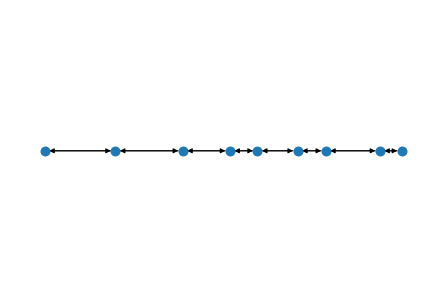

In [4]:
# show graph
nx.draw(FG, positions, node_size=80)

plt.show()

### create path

In [5]:
path_up_1 = nx.dijkstra_path(FG, nodes[0].name, nodes[1].name)
path_up_2 = nx.dijkstra_path(FG, nodes[1].name, nodes[2].name)
path_up_3 = nx.dijkstra_path(FG, nodes[2].name, nodes[3].name)
path_up_4 = nx.dijkstra_path(FG, nodes[3].name, nodes[4].name)
path_up_5 = nx.dijkstra_path(FG, nodes[4].name, nodes[5].name)
path_up_6 = nx.dijkstra_path(FG, nodes[5].name, nodes[6].name)
path_up_7 = nx.dijkstra_path(FG, nodes[6].name, nodes[7].name)
path_up_8 = nx.dijkstra_path(FG, nodes[7].name, nodes[8].name)

### create vessel

In [6]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.Routeable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [7]:
# Create a dict with all important settings

data_vessel = {
    "env": None,
    "name": 'MCV85_9_5_down_loaded_LWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3,
    "use_V_g_profile":None,
    "type": None,
    "B": 9.5,
    "L": 85,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": True, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 2020, # the engine construction year is only used for diesel use and emissions quantification
}             



### prepare input for getting feasible velocities for all water depths

In [8]:


# create lists of strategy values
T_actual = [2]
h = [7.5, 3, 3, 7.5, 7.5, 6.5, 10.6, 5.6]
safety_margin = [0.3]
width = [200]


In [9]:
# prepare the work to be done by creating a list of all combinations
work = list(itertools.product( h,T_actual, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work:
    row = {"h": item[0],"T_actual":item[1], "safety_margin":item[2], "width":item[3]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work_df = pd.DataFrame(rows)
work_df['stretch']= [1,2,3,4,5,6,7,8]
work_df['path']= [path_up_1,path_up_2,path_up_3,path_up_4,path_up_5,path_up_6,path_up_7, path_up_8]
work_df['current'] = [-0.8* 0.2777,-2.4* 0.2777,
                  -3.68* 0.2777,-1* 0.2777,
                  -1.5* 0.2777, -1.9* 0.2777,
                  -0.8* 0.2777,-0.7* 0.2777] # m/s
work_df.head(20)

,h,T_actual,safety_margin,width,stretch,path,current
0,7.5,2,0.3,200,1,"[Node 0, Node 1]",-0.222160
1,3.0,2,0.3,200,2,"[Node 1, Node 2]",-0.666480
2,3.0,2,0.3,200,3,"[Node 2, Node 3]",-1.021936
3,7.5,2,0.3,200,4,"[Node 3, Node 4]",-0.277700
4,7.5,2,0.3,200,5,"[Node 4, Node 5]",-0.416550
5,6.5,2,0.3,200,6,"[Node 5, Node 6]",-0.527630
6,10.6,2,0.3,200,7,"[Node 6, Node 7]",-0.222160
7,5.6,2,0.3,200,8,"[Node 7, Node 8]",-0.194390


In [10]:
feasibilities = []

for i, row in tqdm.tqdm(work_df.iterrows(),disable=True):

    # get vessel 
    data_vessel_i = data_vessel.copy()
    vessel = TransportResource(**data_vessel_i)
    vessel._T = row['T_actual']
    vessel.safety_margin = row['safety_margin']
    vessel.path = row['path']
    
    # estimate 'grounding speed' as a useful upperbound
    upperbound, selected, results_df = opentnsim.strategy.get_upperbound_for_power2v(vessel, width=row['width'], depth=row['h'], margin=0)
    
    # calculate the velocity that belongs to the h (while leaving the margin)
    v, depth, depth_squat, z_computed, margin = opentnsim.strategy.get_v(vessel, width=row['width'], depth=row['h'], margin=row['safety_margin'], bounds=(0, upperbound))
    

    
    feasibility ={}
    feasibility.update(row)
    feasibility['vg_feasible (m/s)'] = v # final max v considering squat and installed power, downstream 
    feasibility['vg_feasible (km/h)'] = v * 3.6 # final max v considering squat and installed power, downstream     
    feasibility['z_computed (m)'] = z_computed     # maxiumum sinkage
    
    feasibilities.append(feasibility)

In [11]:
feasibilities_df = pd.DataFrame(feasibilities)
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(feasibilities_df)

,h,T_actual,safety_margin,width,stretch,path,current,vg_feasible (m/s),vg_feasible (km/h),z_computed (m)
0,7.50,2,0.30,200,1,"[Node 0, Node 1]",-0.22,5.06,18.21,0.14
1,3.00,2,0.30,200,2,"[Node 1, Node 2]",-0.67,4.02,14.46,0.19
2,3.00,2,0.30,200,3,"[Node 2, Node 3]",-1.02,4.02,14.46,0.19
3,7.50,2,0.30,200,4,"[Node 3, Node 4]",-0.28,5.06,18.21,0.14
4,7.50,2,0.30,200,5,"[Node 4, Node 5]",-0.42,5.06,18.21,0.14
5,6.50,2,0.30,200,6,"[Node 5, Node 6]",-0.53,4.86,17.48,0.15
6,10.60,2,0.30,200,7,"[Node 6, Node 7]",-0.22,5.46,19.66,0.13
7,5.60,2,0.30,200,8,"[Node 7, Node 8]",-0.19,4.86,17.48,0.17


### display all the feasible velocities for h

In [12]:

v_feasible_for_h = []
for row in feasibilities:
    max_velocity = row['vg_feasible (km/h)']
    min_velocity = 8
    stepsize = -1.8
    # create lists of strategy values
    v_feasible = np.arange(max_velocity, round(min_velocity + stepsize, 10), stepsize).round(2).tolist()
    v_feasible_for_h.append(v_feasible)
v_df = pd.DataFrame(v_feasible_for_h).T
names=['h=7.5','h=3','h=3','h=7.5','h=7.5','h=6.5','h=10.6','h=5.6']
v_df.columns=names
v_df

,h=7.5,h=3,h=3,h=7.5,h=7.5,h=6.5,h=10.6,h=5.6
0,18.21,14.46,14.46,18.21,18.21,17.48,19.66,17.48
1,16.41,12.66,12.66,16.41,16.41,15.68,17.86,15.68
2,14.61,10.86,10.86,14.61,14.61,13.88,16.06,13.88
3,12.81,9.06,9.06,12.81,12.81,12.08,14.26,12.08
4,11.01,7.26,7.26,11.01,11.01,10.28,12.46,10.28
5,9.21,NaN,NaN,9.21,9.21,8.48,10.66,8.48
6,7.41,NaN,NaN,7.41,7.41,6.68,8.86,6.68
7,NaN,NaN,NaN,NaN,NaN,NaN,7.06,NaN


### prepare input data for simulation

In [13]:
# create a new table of all the v/strategy combinations
# using the itertools.product is more pro
# but for now we'll just loop
rows = []
for feasibility in feasibilities:
    max_velocity = feasibility['vg_feasible (km/h)']
    min_velocity = 8
    stepsize = -1.8
    v_feasible = np.arange(max_velocity, round(min_velocity + stepsize, 2), stepsize).round(2)

    
    for v_feasible_i in v_feasible:
        row = {}
        row.update(feasibility)
        row['max_velocity'] = max_velocity
        row['min_velocity'] = min_velocity
        row['stepsize'] = stepsize
        row['v_feasible'] = v_feasible_i
       
        rows.append(row)
v_flat_df = pd.DataFrame(rows)        

    

In [14]:
v_flat_df['vg_feasible_km_h'] = v_flat_df['v_feasible']
v_flat_df['vg_feasible_m_s'] = v_flat_df['v_feasible'] /3.6
columns = ['stretch','path','h','width','T_actual','vg_feasible_km_h','vg_feasible_m_s']
# select relevant info
# these are all the runs that we want to run a simulation 
runs_df = v_flat_df[columns]
runs_df

,stretch,path,h,width,T_actual,vg_feasible_km_h,vg_feasible_m_s
0,1,"[Node 0, Node 1]",7.5,200,2,18.21,5.058333
1,1,"[Node 0, Node 1]",7.5,200,2,16.41,4.558333
2,1,"[Node 0, Node 1]",7.5,200,2,14.61,4.058333
3,1,"[Node 0, Node 1]",7.5,200,2,12.81,3.558333
4,1,"[Node 0, Node 1]",7.5,200,2,11.01,3.058333
5,1,"[Node 0, Node 1]",7.5,200,2,9.21,2.558333
6,1,"[Node 0, Node 1]",7.5,200,2,7.41,2.058333
7,2,"[Node 1, Node 2]",3.0,200,2,14.46,4.016667
8,2,"[Node 1, Node 2]",3.0,200,2,12.66,3.516667
9,2,"[Node 1, Node 2]",3.0,200,2,10.86,3.016667


### define vessel sailing simulation (vessel passing edges)

In [15]:
def run_simulation(Vg,path):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    data_vessel_i = data_vessel.copy()
    vessel = TransportResource(**data_vessel_i)
    vessel.env = env                                        #the created environment
    vessel.name = 'MCV85_9_5_down_loaded_LWL'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel.V_g_ave = Vg

    # Start the simulation
    env.process(vessel.move())
    env.run()

    return vessel

### define and run energy related simulation

In [16]:
results = []
import time
def run_and_postprocess(row, vessel):
    max_sinkage = (vessel.C_B * ((vessel.B * row['T_actual']) / (row['width'] * row['h'])) ** 0.81) * (
        (row['vg_feasible_m_s']*1.94) ** 2.08) / 20
   
    # incoperate energy module
    data_vessel_i = data_vessel.copy()
    vessel = TransportResource(**data_vessel_i)
    vessel = run_simulation(Vg = row['vg_feasible_m_s'], path = row['path'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    result = {}
    result.update(row)
    result['distance (m)'] = energycalculation.energy_use["distance"][0]
    result['transport time (s)'] = energycalculation.energy_use["sailing_duration"][0]
    result['total_energy'] = energycalculation.energy_use["total_energy"][0]
    result['Fuel Use (g)'] = energycalculation.energy_use["total_diesel_consumption_C_year_ICE_mass"][0]
    result['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"][0]
    result['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"][0]
    result['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"][0]
    result['Safety (remaining space (m))'] = row['h'] - row['T_actual'] - max_sinkage   
    # result['Payload_strategy_tanker (ton)'] = Payload_comupted   
    return result
    
tqdm.tqdm.pandas(desc="Simulating is ongoing")
# predefine the vessel variable
run = functools.partial(run_and_postprocess, vessel=vessel)
results = runs_df.progress_apply(run, axis=1)
results_df = pd.DataFrame(results.values.tolist())



Simulating is ongoing: 100%|███████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 85.30it/s]


In [17]:
results_df.head(73)

,stretch,path,h,width,T_actual,vg_feasible_km_h,vg_feasible_m_s,distance (m),transport time (s),total_energy,Fuel Use (g),CO2 (g),PM10 (g),NOx (g),Safety (remaining space (m))
0,1,"[Node 0, Node 1]",7.5,200,2,18.21,5.058333,48602.089680,9608.320859,1400.968051,268845.768906,853231.571843,20.804376,3328.885584,5.357272
1,1,"[Node 0, Node 1]",7.5,200,2,16.41,4.558333,48602.089680,10662.250021,996.207265,198858.509458,631114.111596,15.101632,2693.032587,5.385055
2,1,"[Node 0, Node 1]",7.5,200,2,14.61,4.058333,48602.089680,11975.874254,731.914876,154730.438104,491065.548300,11.915377,2305.443317,5.409731
3,1,"[Node 0, Node 1]",7.5,200,2,12.81,3.558333,48602.089680,13658.666889,542.369663,119088.827632,377950.331905,9.880081,2093.019119,5.431330
4,1,"[Node 0, Node 1]",7.5,200,2,11.01,3.058333,48602.089680,15891.691449,389.054420,88666.924270,281400.817553,8.878768,1990.489542,5.449883
5,1,"[Node 0, Node 1]",7.5,200,2,9.21,2.558333,48602.089680,18997.559484,265.259972,62312.938433,197761.588815,8.611330,2007.492550,5.465428
6,1,"[Node 0, Node 1]",7.5,200,2,7.41,2.058333,48602.089680,23612.351262,165.196373,39234.138700,124516.766504,6.046187,1424.323132,5.478007
7,2,"[Node 1, Node 2]",3.0,200,2,14.46,4.016667,46331.172068,11534.731635,738.574537,155353.006431,493041.383568,11.916075,2280.388105,0.814414
8,2,"[Node 1, Node 2]",3.0,200,2,12.66,3.516667,46331.172068,13174.740872,465.841739,103394.374338,328141.093293,8.865365,1916.754995,0.859247
9,2,"[Node 1, Node 2]",3.0,200,2,10.86,3.016667,46331.172068,15358.399581,303.277369,69963.912554,222043.364580,7.799528,1773.860655,0.897689


In [18]:
columns = ['stretch','vg_feasible_km_h','transport time (s)','total_energy','Fuel Use (g)','CO2 (g)','PM10 (g)','NOx (g)' ]
# select relevant info

r_df = results_df[columns]
r_df

,stretch,vg_feasible_km_h,transport time (s),total_energy,Fuel Use (g),CO2 (g),PM10 (g),NOx (g)
0,1,18.21,9608.320859,1400.968051,268845.768906,853231.571843,20.804376,3328.885584
1,1,16.41,10662.250021,996.207265,198858.509458,631114.111596,15.101632,2693.032587
2,1,14.61,11975.874254,731.914876,154730.438104,491065.548300,11.915377,2305.443317
3,1,12.81,13658.666889,542.369663,119088.827632,377950.331905,9.880081,2093.019119
4,1,11.01,15891.691449,389.054420,88666.924270,281400.817553,8.878768,1990.489542
5,1,9.21,18997.559484,265.259972,62312.938433,197761.588815,8.611330,2007.492550
6,1,7.41,23612.351262,165.196373,39234.138700,124516.766504,6.046187,1424.323132
7,2,14.46,11534.731635,738.574537,155353.006431,493041.383568,11.916075,2280.388105
8,2,12.66,13174.740872,465.841739,103394.374338,328141.093293,8.865365,1916.754995
9,2,10.86,15358.399581,303.277369,69963.912554,222043.364580,7.799528,1773.860655


In [19]:
s1= r_df.query('stretch == 1 & vg_feasible_km_h <16 ')  # 16km/h is the speed limit for this route
s1

,stretch,vg_feasible_km_h,transport time (s),total_energy,Fuel Use (g),CO2 (g),PM10 (g),NOx (g)
2,1,14.61,11975.874254,731.914876,154730.438104,491065.548300,11.915377,2305.443317
3,1,12.81,13658.666889,542.369663,119088.827632,377950.331905,9.880081,2093.019119
4,1,11.01,15891.691449,389.054420,88666.924270,281400.817553,8.878768,1990.489542
5,1,9.21,18997.559484,265.259972,62312.938433,197761.588815,8.611330,2007.492550
6,1,7.41,23612.351262,165.196373,39234.138700,124516.766504,6.046187,1424.323132


In [20]:
s2= r_df.query('stretch == 2 & vg_feasible_km_h <16 ')
s2

,stretch,vg_feasible_km_h,transport time (s),total_energy,Fuel Use (g),CO2 (g),PM10 (g),NOx (g)
7,2,14.46,11534.731635,738.574537,155353.006431,493041.383568,11.916075,2280.388105
8,2,12.66,13174.740872,465.841739,103394.374338,328141.093293,8.865365,1916.754995
9,2,10.86,15358.399581,303.277369,69963.912554,222043.364580,7.799528,1773.860655
10,2,9.06,18409.737246,183.775357,43646.647266,138520.675271,6.726178,1584.511127
11,2,7.26,22974.134910,92.934730,22071.998370,70049.552721,3.401411,801.283242


In [21]:
s3= r_df.query('stretch == 3 & vg_feasible_km_h <16')
s3

,stretch,vg_feasible_km_h,transport time (s),total_energy,Fuel Use (g),CO2 (g),PM10 (g),NOx (g)
12,3,14.46,8078.746448,336.662026,73559.929133,233455.985617,6.009217,1260.394084
13,3,12.66,9227.383384,216.597436,49482.852339,157042.947160,5.040548,1132.690947
14,3,10.86,10756.783945,133.329789,31473.382678,99886.577656,4.572216,1071.174567
15,3,9.06,12893.893337,69.786690,16574.338777,52601.717276,2.554193,601.700838
16,3,7.26,16090.726397,27.187268,6456.976088,20492.403057,0.995054,234.408622


In [22]:
s4= r_df.query('stretch == 4 & vg_feasible_km_h <16')
s4

,stretch,vg_feasible_km_h,transport time (s),total_energy,Fuel Use (g),CO2 (g),PM10 (g),NOx (g)
19,4,14.61,4680.904584,272.991514,57990.160665,184042.457269,4.488186,879.671253
20,4,12.81,5338.642933,201.451702,44450.642858,141072.303388,3.744197,800.773572
21,4,11.01,6211.445593,143.527194,32818.341076,104155.050889,3.363572,756.479315
22,4,9.21,7425.408900,96.751655,22794.056340,72341.136702,3.246215,759.048901
23,4,7.41,9229.151953,59.124499,14042.068566,44565.091290,2.163957,509.771432


In [23]:
s5= r_df.query('stretch == 5 & vg_feasible_km_h <16')
s5

,stretch,vg_feasible_km_h,transport time (s),total_energy,Fuel Use (g),CO2 (g),PM10 (g),NOx (g)
26,5,14.61,6796.843521,352.619317,75733.540679,240354.342261,5.931237,1195.743353
27,5,12.81,7751.903501,256.818492,57314.545092,181898.266791,4.994635,1090.338815
28,5,11.01,9019.244673,179.561950,41402.419556,131398.205221,4.583934,1041.602761
29,5,9.21,10781.963501,117.304372,27820.160833,88292.405169,4.229988,995.255267
30,5,7.41,13401.063947,68.014280,16153.391401,51265.763234,2.489323,586.419119


In [24]:
s6= r_df.query('stretch == 6 & vg_feasible_km_h <16')
s6

,stretch,vg_feasible_km_h,transport time (s),total_energy,Fuel Use (g),CO2 (g),PM10 (g),NOx (g)
32,6,15.68,4438.001401,290.552556,60962.814275,193476.721093,4.669682,889.872879
33,6,13.88,5013.534724,212.318808,46338.800584,147064.719749,3.775285,789.913919
34,6,12.08,5760.584600,151.118077,34295.528121,108843.176090,3.330573,743.424858
35,6,10.28,6769.247274,101.440933,23754.072223,75387.923951,3.172144,736.872318
36,6,8.48,8206.115799,61.659236,14644.068496,46475.648964,2.256728,531.625931
37,6,6.68,10417.344607,31.401205,7457.786215,23668.658357,1.149284,270.741191


In [25]:
s7= r_df.query('stretch == 7 & vg_feasible_km_h <16')
s7

,stretch,vg_feasible_km_h,transport time (s),total_energy,Fuel Use (g),CO2 (g),PM10 (g),NOx (g)
41,7,14.26,9403.745991,513.599763,109795.250597,348455.453211,8.553536,1704.298703
42,7,12.46,10762.232571,376.805129,83704.072928,265650.294609,7.195392,1558.084218
43,7,10.66,12579.495106,268.204106,61588.592017,195462.742031,6.499235,1467.413010
44,7,8.86,15135.148740,180.309716,42626.668141,135283.583628,6.284572,1474.423868
45,7,7.06,18993.968532,109.578226,26024.828574,82594.587525,4.010563,944.783461


In [26]:
s8= r_df.query('stretch == 8 & vg_feasible_km_h <16')
s8

,stretch,vg_feasible_km_h,transport time (s),total_energy,Fuel Use (g),CO2 (g),PM10 (g),NOx (g)
47,8,15.68,3466.948988,304.859846,61466.444566,195075.084598,4.669698,841.507315
48,8,13.88,3916.553324,221.009376,47100.302003,149481.484779,3.657629,722.998102
49,8,12.08,4500.145706,162.002980,35900.034592,113935.372943,3.063621,660.479277
50,8,10.28,5288.108963,116.438383,26693.645309,84717.200638,2.785295,627.933138
51,8,8.48,6410.584921,77.970390,18418.637354,58454.938550,2.694919,631.796709
52,8,6.68,8137.988044,46.732496,11098.967916,35224.619228,1.710409,402.927585


### Permutation and combination of all the stretches, involving v, delta t, energy efficiency indicators

In [27]:
# prepare the work to be done by creating a list of all combinations
sv = list(itertools.product(s1['vg_feasible_km_h'],s2['vg_feasible_km_h'],s3['vg_feasible_km_h'],s4['vg_feasible_km_h'],s5['vg_feasible_km_h'],s6['vg_feasible_km_h'],s7['vg_feasible_km_h'],s8['vg_feasible_km_h']))

# prepare a list of dictionaries for pandas
rows = []
for item in sv:
    row = {"s1_v": item[0],"s2_v":item[1], "s3_v":item[2], "s4_v":item[3],"s5_v": item[4],"s6_v":item[5], "s7_v":item[6], "s8_v":item[7]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
sv_df = pd.DataFrame(rows)

sv_df

,s1_v,s2_v,s3_v,s4_v,s5_v,s6_v,s7_v,s8_v
0,14.61,14.46,14.46,14.61,14.61,15.68,14.26,15.68
1,14.61,14.46,14.46,14.61,14.61,15.68,14.26,13.88
2,14.61,14.46,14.46,14.61,14.61,15.68,14.26,12.08
3,14.61,14.46,14.46,14.61,14.61,15.68,14.26,10.28
4,14.61,14.46,14.46,14.61,14.61,15.68,14.26,8.48
...,...,...,...,...,...,...,...,...
562495,7.41,7.26,7.26,7.41,7.41,6.68,7.06,13.88
562496,7.41,7.26,7.26,7.41,7.41,6.68,7.06,12.08
562497,7.41,7.26,7.26,7.41,7.41,6.68,7.06,10.28
562498,7.41,7.26,7.26,7.41,7.41,6.68,7.06,8.48


In [28]:
# prepare the work to be done by creating a list of all combinations
st = list(itertools.product(s1['transport time (s)']/3600,s2['transport time (s)']/3600,s3['transport time (s)']/3600,
                            s4['transport time (s)']/3600,s5['transport time (s)']/3600,s6['transport time (s)']/3600,
                            s7['transport time (s)']/3600,s8['transport time (s)']/3600))

# prepare a list of dictionaries for pandas
rows = []
for item in st:
    row = {"s1_t": item[0],"s2_t":item[1], "s3_t":item[2], "s4_t":item[3],"s5_t": item[4],"s6_t":item[5], "s7_t":item[6], "s8_t":item[7]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progresscc
st_df = pd.DataFrame(rows)
st_df['total time (hours)'] = st_df.apply(lambda x: x.sum(), axis=1)
st_df

,s1_t,s2_t,s3_t,s4_t,s5_t,s6_t,s7_t,s8_t,total time (hours)
0,3.326632,3.204092,2.244096,1.300251,1.888012,1.232778,2.612152,0.963041,16.771055
1,3.326632,3.204092,2.244096,1.300251,1.888012,1.232778,2.612152,1.087931,16.895945
2,3.326632,3.204092,2.244096,1.300251,1.888012,1.232778,2.612152,1.250040,17.058054
3,3.326632,3.204092,2.244096,1.300251,1.888012,1.232778,2.612152,1.468919,17.276932
4,3.326632,3.204092,2.244096,1.300251,1.888012,1.232778,2.612152,1.780718,17.588731
...,...,...,...,...,...,...,...,...,...
562495,6.558986,6.381704,4.469646,2.563653,3.722518,2.893707,5.276102,1.087931,32.954249
562496,6.558986,6.381704,4.469646,2.563653,3.722518,2.893707,5.276102,1.250040,33.116358
562497,6.558986,6.381704,4.469646,2.563653,3.722518,2.893707,5.276102,1.468919,33.335236
562498,6.558986,6.381704,4.469646,2.563653,3.722518,2.893707,5.276102,1.780718,33.647035


In [29]:
# prepare the work to be done by creating a list of all combinations
se = list(itertools.product(s1['total_energy']/1000,s2['total_energy']/1000,s3['total_energy']/1000,
                            s4['total_energy']/1000,s5['total_energy']/1000,s6['total_energy']/1000,
                            s7['total_energy']/1000,s8['total_energy']/1000))

# prepare a list of dictionaries for pandas
rows = []
for item in se:
    row = {"s1_e": item[0],"s2_e":item[1], "s3_e":item[2], "s4_e":item[3],"s5_e": item[4],"s6_e":item[5], "s7_e":item[6], "s8_e":item[7]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progresscc
se_df = pd.DataFrame(rows)
se_df['total energy trip (MWh)'] = se_df.apply(lambda x: x.sum(), axis=1)
se_df

,s1_e,s2_e,s3_e,s4_e,s5_e,s6_e,s7_e,s8_e,total energy trip (MWh)
0,0.731915,0.738575,0.336662,0.272992,0.352619,0.290553,0.513600,0.304860,3.541774
1,0.731915,0.738575,0.336662,0.272992,0.352619,0.290553,0.513600,0.221009,3.457924
2,0.731915,0.738575,0.336662,0.272992,0.352619,0.290553,0.513600,0.162003,3.398918
3,0.731915,0.738575,0.336662,0.272992,0.352619,0.290553,0.513600,0.116438,3.353353
4,0.731915,0.738575,0.336662,0.272992,0.352619,0.290553,0.513600,0.077970,3.314885
...,...,...,...,...,...,...,...,...,...
562495,0.165196,0.092935,0.027187,0.059124,0.068014,0.031401,0.109578,0.221009,0.774446
562496,0.165196,0.092935,0.027187,0.059124,0.068014,0.031401,0.109578,0.162003,0.715440
562497,0.165196,0.092935,0.027187,0.059124,0.068014,0.031401,0.109578,0.116438,0.669875
562498,0.165196,0.092935,0.027187,0.059124,0.068014,0.031401,0.109578,0.077970,0.631407


In [30]:
# prepare the work to be done by creating a list of all combinations
sf = list(itertools.product(s1['Fuel Use (g)']/1000,s2['Fuel Use (g)']/1000,s3['Fuel Use (g)']/1000,
                            s4['Fuel Use (g)']/1000,s5['Fuel Use (g)']/1000,s6['Fuel Use (g)']/1000,
                            s7['Fuel Use (g)']/1000,s8['Fuel Use (g)']/1000))

# prepare a list of dictionaries for pandas
rows = []
for item in sf:
    row = {"s1_f": item[0],"s2_f":item[1], "s3_f":item[2], "s4_f":item[3],"s5_f": item[4],"s6_f":item[5], "s7_f":item[6], "s8_f":item[7]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
sf_df = pd.DataFrame(rows)
sf_df['total fuel (kg)'] = sf_df.apply(lambda x: x.sum(), axis=1)
sf_df['total fuel cost (EUR)'] = sf_df['total fuel (kg)']* 1.882 #   1882 EUR/ton diesel
sf_df

,s1_f,s2_f,s3_f,s4_f,s5_f,s6_f,s7_f,s8_f,total fuel (kg),total fuel cost (EUR)
0,154.730438,155.353006,73.559929,57.990161,75.733541,60.962814,109.795251,61.466445,749.591584,1410.731362
1,154.730438,155.353006,73.559929,57.990161,75.733541,60.962814,109.795251,47.100302,735.225442,1383.694282
2,154.730438,155.353006,73.559929,57.990161,75.733541,60.962814,109.795251,35.900035,724.025174,1362.615378
3,154.730438,155.353006,73.559929,57.990161,75.733541,60.962814,109.795251,26.693645,714.818785,1345.288954
4,154.730438,155.353006,73.559929,57.990161,75.733541,60.962814,109.795251,18.418637,706.543777,1329.715389
...,...,...,...,...,...,...,...,...,...,...
562495,39.234139,22.071998,6.456976,14.042069,16.153391,7.457786,26.024829,47.100302,178.541490,336.015084
562496,39.234139,22.071998,6.456976,14.042069,16.153391,7.457786,26.024829,35.900035,167.341223,314.936181
562497,39.234139,22.071998,6.456976,14.042069,16.153391,7.457786,26.024829,26.693645,158.134833,297.609756
562498,39.234139,22.071998,6.456976,14.042069,16.153391,7.457786,26.024829,18.418637,149.859825,282.036191


In [31]:
# prepare the work to be done by creating a list of all combinations
sCO2 = list(itertools.product(s1['CO2 (g)']/1000,s2['CO2 (g)']/1000,s3['CO2 (g)']/1000,
                            s4['CO2 (g)']/1000,s5['CO2 (g)']/1000,s6['CO2 (g)']/1000,
                            s7['CO2 (g)']/1000,s8['CO2 (g)']/1000))

# prepare a list of dictionaries for pandas
rows = []
for item in sCO2:
    row = {"s1_f": item[0],"s2_f":item[1], "s3_f":item[2], "s4_f":item[3],"s5_f": item[4],"s6_f":item[5], "s7_f":item[6], "s8_f":item[7]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
sCO2_df = pd.DataFrame(rows)
sCO2_df['total CO2 (kg)'] = sCO2_df.apply(lambda x: x.sum(), axis=1)

sCO2_df

,s1_f,s2_f,s3_f,s4_f,s5_f,s6_f,s7_f,s8_f,total CO2 (kg)
0,491.065548,493.041384,233.455986,184.042457,240.354342,193.476721,348.455453,195.075085,2378.966976
1,491.065548,493.041384,233.455986,184.042457,240.354342,193.476721,348.455453,149.481485,2333.373376
2,491.065548,493.041384,233.455986,184.042457,240.354342,193.476721,348.455453,113.935373,2297.827264
3,491.065548,493.041384,233.455986,184.042457,240.354342,193.476721,348.455453,84.717201,2268.609092
4,491.065548,493.041384,233.455986,184.042457,240.354342,193.476721,348.455453,58.454939,2242.346830
...,...,...,...,...,...,...,...,...,...
562495,124.516767,70.049553,20.492403,44.565091,51.265763,23.668658,82.594588,149.481485,566.634307
562496,124.516767,70.049553,20.492403,44.565091,51.265763,23.668658,82.594588,113.935373,531.088196
562497,124.516767,70.049553,20.492403,44.565091,51.265763,23.668658,82.594588,84.717201,501.870023
562498,124.516767,70.049553,20.492403,44.565091,51.265763,23.668658,82.594588,58.454939,475.607761


In [32]:
# prepare the work to be done by creating a list of all combinations
sPM10 = list(itertools.product(s1['PM10 (g)']/1000,s2['PM10 (g)']/1000,s3['PM10 (g)']/1000,
                            s4['PM10 (g)']/1000,s5['PM10 (g)']/1000,s6['PM10 (g)']/1000,
                            s7['PM10 (g)']/1000,s8['PM10 (g)']/1000))

# prepare a list of dictionaries for pandas
rows = []
for item in sPM10:
    row = {"s1_f": item[0],"s2_f":item[1], "s3_f":item[2], "s4_f":item[3],"s5_f": item[4],"s6_f":item[5], "s7_f":item[6], "s8_f":item[7]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
sPM10_df = pd.DataFrame(rows)
sPM10_df['total PM10 (kg)'] = sPM10_df.apply(lambda x: x.sum(), axis=1)

sPM10_df

,s1_f,s2_f,s3_f,s4_f,s5_f,s6_f,s7_f,s8_f,total PM10 (kg)
0,0.011915,0.011916,0.006009,0.004488,0.005931,0.004670,0.008554,0.004670,0.058153
1,0.011915,0.011916,0.006009,0.004488,0.005931,0.004670,0.008554,0.003658,0.057141
2,0.011915,0.011916,0.006009,0.004488,0.005931,0.004670,0.008554,0.003064,0.056547
3,0.011915,0.011916,0.006009,0.004488,0.005931,0.004670,0.008554,0.002785,0.056269
4,0.011915,0.011916,0.006009,0.004488,0.005931,0.004670,0.008554,0.002695,0.056178
...,...,...,...,...,...,...,...,...,...
562495,0.006046,0.003401,0.000995,0.002164,0.002489,0.001149,0.004011,0.003658,0.023913
562496,0.006046,0.003401,0.000995,0.002164,0.002489,0.001149,0.004011,0.003064,0.023319
562497,0.006046,0.003401,0.000995,0.002164,0.002489,0.001149,0.004011,0.002785,0.023041
562498,0.006046,0.003401,0.000995,0.002164,0.002489,0.001149,0.004011,0.002695,0.022951


In [33]:
# prepare the work to be done by creating a list of all combinations
sNOx = list(itertools.product(s1['NOx (g)']/1000,s2['NOx (g)']/1000,s3['NOx (g)']/1000,
                            s4['NOx (g)']/1000,s5['NOx (g)']/1000,s6['NOx (g)']/1000,
                            s7['NOx (g)']/1000,s8['NOx (g)']/1000))

# prepare a list of dictionaries for pandas
rows = []
for item in sNOx:
    row = {"s1_f": item[0],"s2_f":item[1], "s3_f":item[2], "s4_f":item[3],"s5_f": item[4],"s6_f":item[5], "s7_f":item[6], "s8_f":item[7]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
sNOx_df = pd.DataFrame(rows)
sNOx_df['total NOx (kg)'] = sNOx_df.apply(lambda x: x.sum(), axis=1)

sNOx_df

,s1_f,s2_f,s3_f,s4_f,s5_f,s6_f,s7_f,s8_f,total NOx (kg)
0,2.305443,2.280388,1.260394,0.879671,1.195743,0.889873,1.704299,0.841507,11.357319
1,2.305443,2.280388,1.260394,0.879671,1.195743,0.889873,1.704299,0.722998,11.238810
2,2.305443,2.280388,1.260394,0.879671,1.195743,0.889873,1.704299,0.660479,11.176291
3,2.305443,2.280388,1.260394,0.879671,1.195743,0.889873,1.704299,0.627933,11.143745
4,2.305443,2.280388,1.260394,0.879671,1.195743,0.889873,1.704299,0.631797,11.147608
...,...,...,...,...,...,...,...,...,...
562495,1.424323,0.801283,0.234409,0.509771,0.586419,0.270741,0.944783,0.722998,5.494728
562496,1.424323,0.801283,0.234409,0.509771,0.586419,0.270741,0.944783,0.660479,5.432209
562497,1.424323,0.801283,0.234409,0.509771,0.586419,0.270741,0.944783,0.627933,5.399663
562498,1.424323,0.801283,0.234409,0.509771,0.586419,0.270741,0.944783,0.631797,5.403527


In [34]:
s=pd.concat([sv_df,st_df,se_df,sf_df,sCO2_df,sPM10_df,sNOx_df],axis=1)
s

,s1_v,s2_v,s3_v,s4_v,s5_v,s6_v,s7_v,s8_v,s1_t,s2_t,...,total PM10 (kg),s1_f,s2_f,s3_f,s4_f,s5_f,s6_f,s7_f,s8_f,total NOx (kg)
0,14.61,14.46,14.46,14.61,14.61,15.68,14.26,15.68,3.326632,3.204092,...,0.058153,2.305443,2.280388,1.260394,0.879671,1.195743,0.889873,1.704299,0.841507,11.357319
1,14.61,14.46,14.46,14.61,14.61,15.68,14.26,13.88,3.326632,3.204092,...,0.057141,2.305443,2.280388,1.260394,0.879671,1.195743,0.889873,1.704299,0.722998,11.238810
2,14.61,14.46,14.46,14.61,14.61,15.68,14.26,12.08,3.326632,3.204092,...,0.056547,2.305443,2.280388,1.260394,0.879671,1.195743,0.889873,1.704299,0.660479,11.176291
3,14.61,14.46,14.46,14.61,14.61,15.68,14.26,10.28,3.326632,3.204092,...,0.056269,2.305443,2.280388,1.260394,0.879671,1.195743,0.889873,1.704299,0.627933,11.143745
4,14.61,14.46,14.46,14.61,14.61,15.68,14.26,8.48,3.326632,3.204092,...,0.056178,2.305443,2.280388,1.260394,0.879671,1.195743,0.889873,1.704299,0.631797,11.147608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562495,7.41,7.26,7.26,7.41,7.41,6.68,7.06,13.88,6.558986,6.381704,...,0.023913,1.424323,0.801283,0.234409,0.509771,0.586419,0.270741,0.944783,0.722998,5.494728
562496,7.41,7.26,7.26,7.41,7.41,6.68,7.06,12.08,6.558986,6.381704,...,0.023319,1.424323,0.801283,0.234409,0.509771,0.586419,0.270741,0.944783,0.660479,5.432209
562497,7.41,7.26,7.26,7.41,7.41,6.68,7.06,10.28,6.558986,6.381704,...,0.023041,1.424323,0.801283,0.234409,0.509771,0.586419,0.270741,0.944783,0.627933,5.399663
562498,7.41,7.26,7.26,7.41,7.41,6.68,7.06,8.48,6.558986,6.381704,...,0.022951,1.424323,0.801283,0.234409,0.509771,0.586419,0.270741,0.944783,0.631797,5.403527


In [35]:
import os  
os.makedirs('folder/subfolder', exist_ok=True)  
s.to_csv('folder/subfolder/Scenario_1_downstream.csv') 

In [36]:
# s.rename(columns = {'total CO2 (kg)':'tot_CO'}, inplace = True)           #renaming column so that it doesnt have spaces in it (else finding min doesnt work)

# t_max_1 = 26  #You can pick relevant values here
# t_max_2 = 30  #You can pick relevant values here

# Graph_df_1 = s.loc[s['total time (hours)'] <= t_max_1]    
# Graph_df_2 = s.loc[s['total time (hours)'] <= t_max_2]
# Graph_df_1 = Graph_df_1.loc[Graph_df_1.tot_CO == Graph_df_1.tot_CO.min()]
# Graph_df_2 = Graph_df_2.loc[Graph_df_2.tot_CO == Graph_df_2.tot_CO.min()]

# x = np.array(range(0, 9))
# y_1 = np.array(Graph_df_1)
# y_1 = np.insert(y_1[0,:],0,y_1[0,0])  #duplicates 0th entry (important for plt.step else results of waterwaystretch 1 doesnt show)
# y_2 = np.array(Graph_df_2)
# y_2 = np.insert(y_2[0,:],0,y_2[0,0])

# plt.figure(figsize=(10,6))
# plt.step(x, y_1)
# plt.step(x, y_2)
# plt.xlabel("Waterway stretch")
# plt.ylabel("Vessel speed [km/h]")
# plt.title("Optimal vessel speed per waterway stretch [-]")
# plt.legend(["Scenario 1A", "Scenario 1B"], loc ="upper right")
# #plt.savefig('Vessel_speeds.png')

# #Notes:
# #Scenario 1A: ICE, upstream,  t_max_1
# #Scenario 1B: ICE, upstream,  t_max_2
# #Scenario 1C: ICE, downstream,  t_max_1
# #Scenario 1D: ICE, downstream,  t_max_2

# #Scenario 2A: H2, upstream,  t_max_1
# #Scenario 2B: H2, upstream,  t_max_2
# #Scenario 2C: H2, downstream,  t_max_1
# #Scenario 2D: H2, downstream,  t_max_2

# #To get all the 8 scenarios in a single graph (or in 2 graphs: ICE and H2) you need to save the y_1 and y_2 from the 4 different files and use them in a single graph.


#### Advanced Parallel Coordinates Plot

In [37]:

fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = s['total time (hours)'],
                   colorscale = 'plasma',
                   showscale = True,
                   cmin = 15,
                   cmax = 36),
        dimensions = list([
            dict(range = [5,16],
                 # constraintrange = [2,3.5],
                 label = "VOG 1 [km/h]", values = s['s1_v']), 
            dict(range = [5,16],
                 # constraintrange = [2,3.5],
                 label = "V2", values = s['s2_v']),
            dict(range = [5,16],
                 # constraintrange = [2,3.5],
                 label = "V3", values = s['s3_v']), 
            dict(range = [5,16],
                 # constraintrange = [2,3.5],
                 label = "V4", values = s['s4_v']),
            dict(range = [5,16],
                 # constraintrange = [2,3.5],
                 label = "V5", values = s['s5_v']), 
            dict(range = [5,16],
                 # constraintrange = [2,3.5],
                 label = "V6", values = s['s6_v']),
            dict(range = [5,16],
                 # constraintrange = [2,3.5],
                 label = "V7", values = s['s7_v']), 
            dict(range = [5,16],
                 # constraintrange = [2,3.5],
                 label = "V8", values = s['s8_v']),
            dict(range = [0,10],
                 label = 'total energy[MWh]', values = s['total energy trip (MWh)']),
            dict(range = [0,8000],
                 label = 'CO2[kg]', values = s['total CO2 (kg)']),
            dict(range = [0,0.25],                
                 label = 'PM10[kg]', values = s['total PM10 (kg)']),
            dict(range = [0,35],                 
                 label = 'NOx[kg]', values = s['total NOx (kg)']),
            dict(range = [0,2500],
                 # constraintrange = [8,20],
                 label = 'diesel[kg]', values = s['total fuel (kg)']),
            dict(range = [0,8000],
                 # constraintrange = [8,20],
                 label = 'fuel cost[EUR]', values = s['total fuel cost (EUR)']),            
            dict(range = [10,40],                 
                 label = 'time[hours]', values = s['total time (hours)']),               
           
        ]),
        unselected = dict(line = dict(color = 'gainsboro', opacity = 0.5))
    )
)
# fig.show()

In [38]:
# If you need to save this file as a standalone html file:
# fig.write_html("C:/interactiveCharts/energy_efficient_adaptive_speed_autonomousICE_downstream_stageV.html")